In [ ]:
# Download Dataset
!gdown 1d7JABk4jViI-USjLsWmhGkvzi8uQIL5C

Downloading...
From: https://drive.google.com/uc?id=1d7JABk4jViI-USjLsWmhGkvzi8uQIL5C
To: /content/data.zip
100% 151k/151k [00:00<00:00, 25.8MB/s]


In [ ]:
# Unzip Dataset
!unzip ./data.zip

Archive:  ./data.zip
   creating: data/
  inflating: __MACOSX/._data         
  inflating: data/restaurants_train.csv  
  inflating: __MACOSX/data/._restaurants_train.csv  
  inflating: data/restaurants_test.csv  
  inflating: __MACOSX/data/._restaurants_test.csv  


##**Dataset**

In [ ]:
import torch
from torch.utils.data import Dataset

class ABSADataset(Dataset):
    def __init__(self, df, tokenizer):
        # Initialize the dataset with a DataFrame and a tokenizer
        self.df = df
        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        # Retrieve tokens, tags, and polarity labels for the sample at the given index
        tokens, tags, pols = self.df.iloc[idx, :3].values

        # Convert string representations of lists into actual lists
        tokens = tokens.replace("'", "").strip("][").split(', ')
        tags = tags.strip('][').split(', ')
        pols = pols.strip('][').split(', ')

        bert_tokens = []  # List to store tokenized text
        bert_att = []     # List to store tokens used in attention
        pols_label = 0    # Initialize polarity label

        for i in range(len(tokens)):
            # Tokenize each token using the provided tokenizer
            t = self.tokenizer.tokenize(tokens[i])
            bert_tokens += t  # Add tokenized text to bert_tokens list

            # If polarity is not -1, it indicates this token should be attended to
            if int(pols[i]) != -1:
                bert_att += t  # Add to the attention list
                pols_label = int(pols[i])  # Set the polarity label

        # Create segment tensor to distinguish between segments in BERT
        segment_tensor = [0] + [0]*len(bert_tokens) + [0] + [1]*len(bert_att)

        # Add special tokens [CLS] and [SEP] for BERT input format
        bert_tokens = ['[CLS]'] + bert_tokens + ['[SEP]'] + bert_att

        # Convert tokens to their corresponding IDs using the tokenizer
        bert_ids = self.tokenizer.convert_tokens_to_ids(bert_tokens)

        # Convert the IDs, polarity label, and segment information to tensors
        ids_tensor = torch.tensor(bert_ids)
        pols_tensor = torch.tensor(pols_label)
        segment_tensor = torch.tensor(segment_tensor)

        # Return the processed tokens, IDs, segment tensor, and polarity label
        return bert_tokens, ids_tensor, segment_tensor, pols_tensor

    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.df)


- **\__init__(self, df, tokenizer)**
  - Purpose: Initializes the dataset.
  - Parameters:
    - df: A DataFrame containing the dataset. It expects columns for tokens, tags, and polarities.
    - tokenizer: A tokenizer object, likely from a BERT model or similar, used to tokenize the input text.
- **\__getitem__(self, idx)**
  - Purpose: Retrieves a single item (data point) from the dataset.
  - Parameters:
    - idx: The index of the item to retrieve.
  - Process:
    - Data Extraction: It extracts tokens, tags, and polarities (pols) from the DataFrame at the given index.
    - Token, Tag, and Polarity Processing:
      - tokens: A string representing a list of tokens, which is then processed into a Python list of tokens.
      - tags: A string representing a list of tags associated with the tokens.
      - pols: A string representing the polarity labels associated with each token.
- **BERT Tokenization:**
  - Each token is further tokenized using the tokenizer (to handle subwords in BERT).
  - bert_tokens: This list stores the tokenized text, with [CLS] and [SEP] tokens added at the beginning and end, respectively.
  - bert_att: This list stores the tokens that are included in the attention mechanism (based on the polarity labels).
- **Segment and ID Conversion:**
  - segment_tensor: A tensor indicating which tokens belong to the first or second part of the input (useful in BERT for distinguishing between pairs of sentences).
  - bert_ids: Converts the tokens into their corresponding IDs as understood by the BERT model.
- **Tensor Creation:**
  - ids_tensor: A tensor of the token IDs.
  - pols_tensor: A tensor containing the polarity label for this instance.
  - segment_tensor: A tensor used to distinguish between sentence segments in BERT.
  - Return: It returns the tokenized text (bert_tokens), their corresponding IDs (ids_tensor), the segment information (segment_tensor), and the polarity label (pols_tensor).
- **\__len__(self)**
  - Purpose: Returns the length of the dataset, i.e., the number of samples.

In [ ]:
import pandas as pd

train_df = pd.read_csv('./data/restaurants_train.csv')
test_df = pd.read_csv('./data/restaurants_test.csv')

In [ ]:
train_df.iloc[0]

Tokens        ['But', 'the', 'staff', 'was', 'so', 'horrible...
Tags                                [0, 0, 1, 0, 0, 0, 0, 0, 0]
Polarities                  [-1, -1, 0, -1, -1, -1, -1, -1, -1]
Name: 0, dtype: object

In [ ]:
from transformers import BertTokenizer

model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
tokenizer.all_special_tokens

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']

- **[UNK] (Unknown Token):** This token is used to represent any word or token that is not in the model's vocabulary. If the tokenizer encounters a word it doesn't recognize, it substitutes it with [UNK].
- **[SEP] (Separator Token):** This token is used to separate different segments of input text, such as in tasks where there are pairs of sentences or question-answer pairs. It helps the model distinguish between different parts of the input.
- **[PAD] (Padding Token):** This token is used to pad shorter sequences to a uniform length, ensuring that all input sequences in a batch have the same length. Padding is necessary for efficient batch processing in models like BERT.
- **[CLS] (Classification Token):** This token is added at the beginning of every input sequence. In classification tasks, the hidden state corresponding to this token is often used as the aggregate representation of the sequence for making predictions.
- **[MASK] (Masking Token):** This token is used in masked language modeling, where certain tokens in the input are replaced with [MASK], and the model's task is to predict the original token. This technique is part of how BERT is pre-trained.

In [ ]:
tokenizer.cls_token_id

101

In [ ]:
tokenizer.sep_token_id

102

In [ ]:
train_ds = ABSADataset(train_df, tokenizer)
test_ds = ABSADataset(test_df, tokenizer)

In [ ]:
next(iter(train_ds))

(['[CLS]',
  'but',
  'the',
  'staff',
  'was',
  'so',
  'horrible',
  'to',
  'us',
  '[SEP]',
  'staff'],
 tensor([ 101, 2021, 1996, 3095, 2001, 2061, 9202, 2000, 2149,  102, 3095]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]),
 tensor(0))

In [ ]:
from torch.nn.utils.rnn import pad_sequence

def padding(samples):
    """
    Pads and processes a batch of samples for input into a model.

    Args:
        samples (list of tuples): Each tuple contains the following elements:
            - The first element (not used here) might be the original text or tokenized text.
            - ids_tensor (torch.Tensor): Tensor of token IDs.
            - segments_tensor (torch.Tensor): Tensor of segment IDs.
            - label_id (torch.Tensor): Tensor containing the label.

    Returns:
        tuple: A tuple containing:
            - ids_tensors (torch.Tensor): Padded tensor of token IDs.
            - segments_tensors (torch.Tensor): Padded tensor of segment IDs.
            - masks_tensors (torch.Tensor): Attention mask tensor, indicating which tokens are real input tokens and which are padding.
            - label_ids (torch.Tensor): Stacked tensor of labels for the batch.
    """

    # Extract the token ID tensors from each sample in the batch
    ids_tensors = [s[1] for s in samples]
    # Pad the token ID sequences to ensure all sequences in the batch have the same length
    ids_tensors = pad_sequence(ids_tensors, batch_first=True)

    # Extract the segment ID tensors from each sample in the batch
    segments_tensors = [s[2] for s in samples]
    # Pad the segment ID sequences to ensure all sequences in the batch have the same length
    segments_tensors = pad_sequence(segments_tensors, batch_first=True)

    # Stack the label tensors from each sample into a single tensor
    label_ids = torch.stack([s[3] for s in samples])

    # Initialize an attention mask tensor with zeros, having the same shape as the padded token ID tensor
    masks_tensors = torch.zeros(ids_tensors.shape, dtype=torch.long)
    # Set the mask to 1 for all positions where the token ID is not 0 (indicating a non-padding token)
    masks_tensors = masks_tensors.masked_fill(ids_tensors != 0, 1)

    # Return the padded token IDs, segment IDs, attention masks, and labels
    return ids_tensors, segments_tensors, masks_tensors, label_ids


In [ ]:
# Initialize Train and Test Loader
from torch.utils.data import DataLoader

batch_size = 32
train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, collate_fn=padding
)
test_loader = DataLoader(
    test_ds, batch_size=batch_size, shuffle=True, collate_fn=padding
)

In [ ]:
a = next (iter(train_loader))

In [ ]:
a[0].shape, a[1].shape, a[2].shape, a[3].shape

(torch.Size([32, 43]),
 torch.Size([32, 43]),
 torch.Size([32, 43]),
 torch.Size([32]))

##**Model**

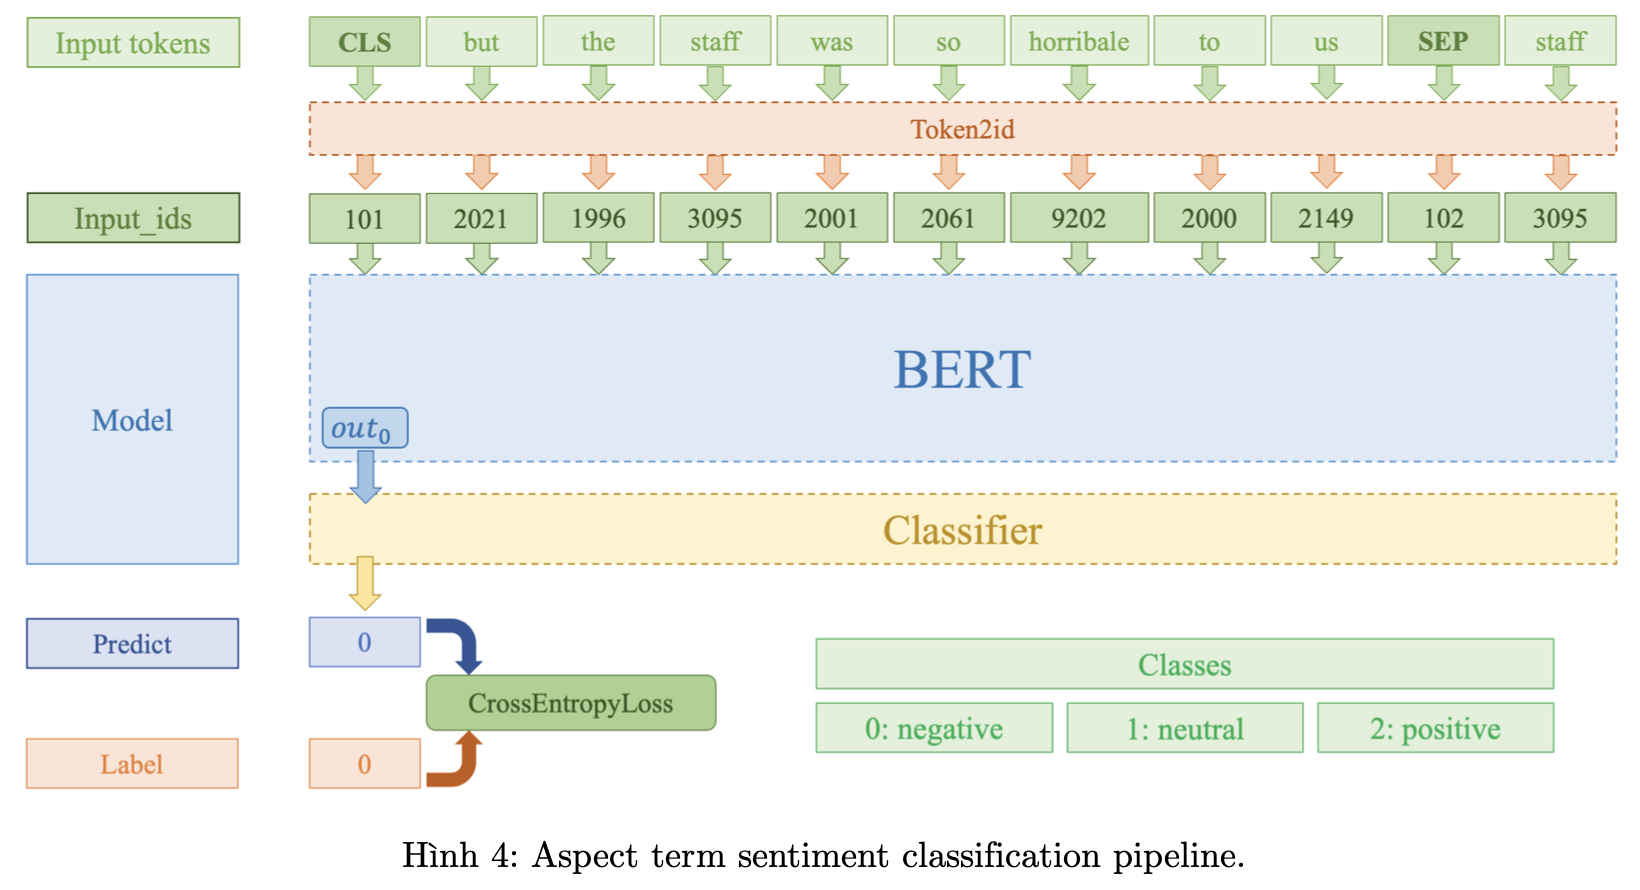

In [ ]:
from transformers import BertModel

class ABSABert(torch.nn.Module):
    def __init__(self, model_name):
        # Initialize the parent class (torch.nn.Module)
        super(ABSABert, self).__init__()

        # Load a pre-trained BERT model using the specified model name
        self.bert = BertModel.from_pretrained(model_name)

        # Define a linear layer that maps the output from BERT's hidden size to 3 classes (for classification)
        self.linear = torch.nn.Linear(self.bert.config.hidden_size, 3)

        # Define the loss function, Cross Entropy Loss, which is commonly used for multi-class classification
        self.loss_fn = torch.nn.CrossEntropyLoss()

    def forward(self, ids_tensors, masks_tensors, segments_tensors, lable_tensors=None):
        # Pass the input tensors through the BERT model
        out_dict = self.bert(
            input_ids=ids_tensors,        # Token IDs from the input text
            attention_mask=masks_tensors, # Attention masks to differentiate real tokens from padding tokens
            token_type_ids=segments_tensors # Segment IDs to distinguish between different parts of the input
        )

        # Apply the linear layer to the output of BERT's pooled output (the representation of the [CLS] token)
        linear_outputs = self.linear(out_dict['pooler_output'])

        # If label tensors are provided (during training), calculate the loss
        if lable_tensors is not None:
            loss = self.loss_fn(linear_outputs, lable_tensors)
            # Return both the loss and the linear output (logits)
            return loss, linear_outputs
        else:
            # If label tensors are not provided (during inference), return only the linear output (logits)
            return linear_outputs


In [ ]:
model = ABSABert(model_name)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model.to(device)

ABSABert(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affi

In [ ]:
import time
import numpy as np

def train_epoch(model, optimizer, train_loader, device):
    losses = []
    for batch in (train_loader):
        ids_tensors, segments_tensors, masks_tensors, label_ids = batch
        ids_tensors = ids_tensors.to(device)
        segments_tensors = segments_tensors.to(device)
        label_ids = label_ids.to(device)
        masks_tensors = masks_tensors.to(device)

        loss, _ = model(
            ids_tensors=ids_tensors,
            masks_tensors=masks_tensors,
            segments_tensors=segments_tensors,
            lable_tensors=label_ids
        )
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return sum(losses)/len(losses)

def evaluate_epoch(model, valid_loader, device):
    losses = []

    preds, labels = [], []
    with torch.no_grad():
        for batch in (valid_loader):
            ids_tensors, segments_tensors, masks_tensors, label_ids = batch
            ids_tensors = ids_tensors.to(device)
            segments_tensors = segments_tensors.to(device)
            masks_tensors = masks_tensors.to(device)
            label_ids = label_ids.to(device)

            loss, outputs = model(
                ids_tensors=ids_tensors,
                masks_tensors=masks_tensors,
                segments_tensors=segments_tensors,
                lable_tensors=label_ids
            )
            losses.append(loss.item())

            _, p = torch.max(outputs, dim=1)
            preds += list([int(i) for i in p])
            labels += list([int(i) for i in label_ids])

    acc = np.mean(np.array(preds) == np.array(labels))
    return sum(losses)/len(losses), acc

def train(model, model_name, save_model, optimizer, train_loader, valid_loader, num_epochs, device):
    train_losses = []
    eval_accs, eval_losses = [], []
    best_loss_eval = 100
    times = []
    for epoch in range(1, num_epochs+1):
        epoch_start_time = time.time()
        # Training
        train_loss = train_epoch(model, optimizer, train_loader, device)
        train_losses.append(train_loss)

        # Evaluation
        eval_loss, eval_acc = evaluate_epoch(model, valid_loader, device)
        eval_accs.append(eval_acc)
        eval_losses.append(eval_loss)

        # Save best model
        if eval_loss < best_loss_eval:
            torch.save(model.state_dict(), save_model + f'/{model_name}.pt')

        times.append(time.time() - epoch_start_time)
        # Print loss, acc end epoch
        print("-" * 59)
        print(
            "| End of epoch {:3d} | Time: {:5.2f}s | Train Loss {:8.3f} "
            "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
                epoch, time.time() - epoch_start_time, train_loss, eval_acc, eval_loss
            )
        )
        print("-" * 59)

    # Load best model
    model.load_state_dict(torch.load(save_model + f'/{model_name}.pt'))
    model.eval()
    metrics = {
        'train_loss': train_losses,
        'valid_accuracy': eval_accs,
        'valid_loss': eval_losses,
        'time': times
    }
    return model, metrics

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

In [ ]:
loss = train_epoch(model, optimizer, train_loader, device)
loss

0.8333718278239258

In [ ]:
loss, acc = evaluate_epoch(model, test_loader, device)
loss, acc

(0.5790388328688485, 0.7640750670241286)

##**Training**

In [ ]:
# Create directory to save model's weights
mkdir "./model"

In [ ]:
save_model = "./model"
model = ABSABert(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
num_epochs = 20
best_model, metrics = train(
    model, model_name, save_model, optimizer, train_loader, test_loader, num_epochs, device
)

-----------------------------------------------------------
| End of epoch   1 | Time: 41.14s | Train Loss    0.814 | Valid Accuracy    0.761 | Valid Loss    0.621 
-----------------------------------------------------------
-----------------------------------------------------------
| End of epoch   2 | Time: 37.18s | Train Loss    0.524 | Valid Accuracy    0.796 | Valid Loss    0.522 
-----------------------------------------------------------
-----------------------------------------------------------
| End of epoch   3 | Time: 41.25s | Train Loss    0.321 | Valid Accuracy    0.793 | Valid Loss    0.526 
-----------------------------------------------------------
-----------------------------------------------------------
| End of epoch   4 | Time: 36.68s | Train Loss    0.201 | Valid Accuracy    0.807 | Valid Loss    0.551 
-----------------------------------------------------------
-----------------------------------------------------------
| End of epoch   5 | Time: 38.33s | Trai

##**Prediction**

In [ ]:
test_df.iloc[0]

Tokens        ['The', 'bread', 'is', 'top', 'notch', 'as', '...
Tags                                   [0, 1, 0, 0, 0, 0, 0, 0]
Polarities                      [-1, 2, -1, -1, -1, -1, -1, -1]
Name: 0, dtype: object

In [ ]:
def predict(model, tokenizer, sentence, aspect, device):
    t1 = tokenizer.tokenize(sentence)
    t2 = tokenizer.tokenize(aspect)

    word_pieces = ['[CLS]'] + t1 + ['[SEP]'] + t2

    segment_tensor = [0] + [0]*len(t1) + [0] + [1]*len(t2)

    input_ids = tokenizer.convert_tokens_to_ids(word_pieces)
    input_tensor = torch.tensor([input_ids]).to(device)
    segment_tensor = torch.tensor([segment_tensor]).to(device)

    with torch.no_grad():
        outputs = model(input_tensor, None, segment_tensor, None)
        _, predictions = torch.max(outputs, dim=1)

    return word_pieces, int(predictions), outputs

In [ ]:
" ".join(test_df.iloc[0]["Tokens"].replace("'", "").strip("][").split(', '))

'The bread is top notch as well'

In [ ]:
sentence = " ".join(test_df.iloc[0]["Tokens"].replace("'", "").strip("][").split(', '))
aspect = "bread"
predict(best_model, tokenizer, sentence, aspect, device)

(['[CLS]',
  'the',
  'bread',
  'is',
  'top',
  'notch',
  'as',
  'well',
  '[SEP]',
  'bread'],
 2,
 tensor([[-1.9999, -4.0468,  5.3199]], device='cuda:0'))